In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import pandas as pd
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_cards = pd.read_csv("pokemon_cards.csv", sep=';', encoding='cp1252')

In [3]:
all_cards.rename(columns=lambda x: x.strip(), inplace=True)
all_cards.drop(all_cards[all_cards["name"] == "name"].index, inplace=True) #usuwam tu linijki z samym name - było tak przez scrappera
all_cards = all_cards.dropna(subset=["name"])  #usuwam linijki bez imienia - w pobranych danych były linijki z samą datą
all_cards.head(5)

,name,set,number,rarity,prices.1st Edition Holofoil,prices.Unlimited Holofoil,prices.Holofoil,prices.Normal,prices.Reverse Holofoil,prices.Date:
0,Lt. Surge's Electabuzz,Gym Heroes,6/132,Rare Holo,$100.00,$35.39,NaN,NaN,NaN,25.11.2025
1,Exeggcute,Plasma Blast,102/101,Rare Secret,NaN,NaN,$100.00,NaN,NaN,25.11.2025
2,Haunter,Skyridge,63/144,Common,NaN,NaN,NaN,$19.49,$99.99,25.11.2025
3,Tauros,Legendary Collection,65/110,Uncommon,NaN,NaN,NaN,$1.36,$99.99,25.11.2025
4,Regigigas LV.X,Stormfront,100/100,Rare Holo LV.X,NaN,NaN,$100.49,NaN,NaN,25.11.2025


In [4]:
price_cols = ['prices.1st Edition Holofoil', 'prices.Unlimited Holofoil', 
              'prices.Holofoil','prices.Normal', 'prices.Reverse Holofoil']

for col in price_cols:
    if col in all_cards.columns:
        all_cards[col] = (all_cards[col].astype(str)
                          .str.replace('$', '', regex=False)
                          .str.replace(',', '', regex=False))
    #zmiana stringa na float, gdy się nie da (np. '') to zmienia na NaN
    all_cards[col] = pd.to_numeric(all_cards[col], errors='coerce')

#zmieniamy string na typ danych data
all_cards['prices.Date:'] = pd.to_datetime(all_cards['prices.Date:'], format='mixed', dayfirst=True)

#stapiamy dane - rozwiązanie problemu z NaN oraz tego, że 1 karta ma kilka cen (bo ma różne wydania)
all_cards = all_cards.melt(
    id_vars=['name', 'set', 'number', 'prices.Date:'], 
    value_vars=[c for c in price_cols if c in all_cards.columns],
    var_name='variant_type', 
    value_name='price'
)

all_cards = all_cards.dropna(subset=['price'])    #gdyby przy którejś karcie nie było ceny w danej wersji wydania to ją usuwa
all_cards['variant_type'] = all_cards['variant_type'].str.replace('prices.', '', regex=False)

#unikalna nazwa karty
all_cards['full_name'] = (
    all_cards['name'] + 
    " (" + all_cards['set'] + ") - " + 
    all_cards['variant_type']
)

#szukamy pełnych nazw 100 najdroższych kart
cards_names = all_cards.groupby('full_name')['price'].max().sort_values(ascending=False).head(100).index
#zostawiamy wiersze których pełna nazwa znajduje się na liście 100 najdroższych kart
cards = all_cards[all_cards['full_name'].isin(cards_names)].copy()

cards.reset_index(drop=True, inplace=True)
cards.head(5)

,name,set,number,prices.Date:,variant_type,price,full_name
0,Lt. Surge's Electabuzz,Gym Heroes,6/132,2025-11-25,1st Edition Holofoil,100.00,Lt. Surge's Electabuzz (Gym Heroes) - 1st Edit...
1,Giovanni,Gym Challenge,18/132,2025-11-25,1st Edition Holofoil,99.79,Giovanni (Gym Challenge) - 1st Edition Holofoil
2,Giovanni's Persian,Gym Challenge,8/132,2025-11-25,1st Edition Holofoil,99.49,Giovanni's Persian (Gym Challenge) - 1st Editi...
3,Koga's Ditto,Gym Challenge,10/132,2025-11-25,1st Edition Holofoil,97.66,Koga's Ditto (Gym Challenge) - 1st Edition Hol...
4,Misty's Golduck,Gym Challenge,12/132,2025-11-25,1st Edition Holofoil,98.64,Misty's Golduck (Gym Challenge) - 1st Edition ...


In [5]:
#interesuje nas top 15 kart
#szukamy pełnych nazw 15 najdroższych kart
top_cards_names = cards.groupby('full_name')['price'].max().sort_values(ascending=False).head(15).index
#zostawiamy wiersze których pełna nazwa znajduje się na liście 100 najdroższych kart
top_cards_data = cards[cards['full_name'].isin(top_cards_names)]

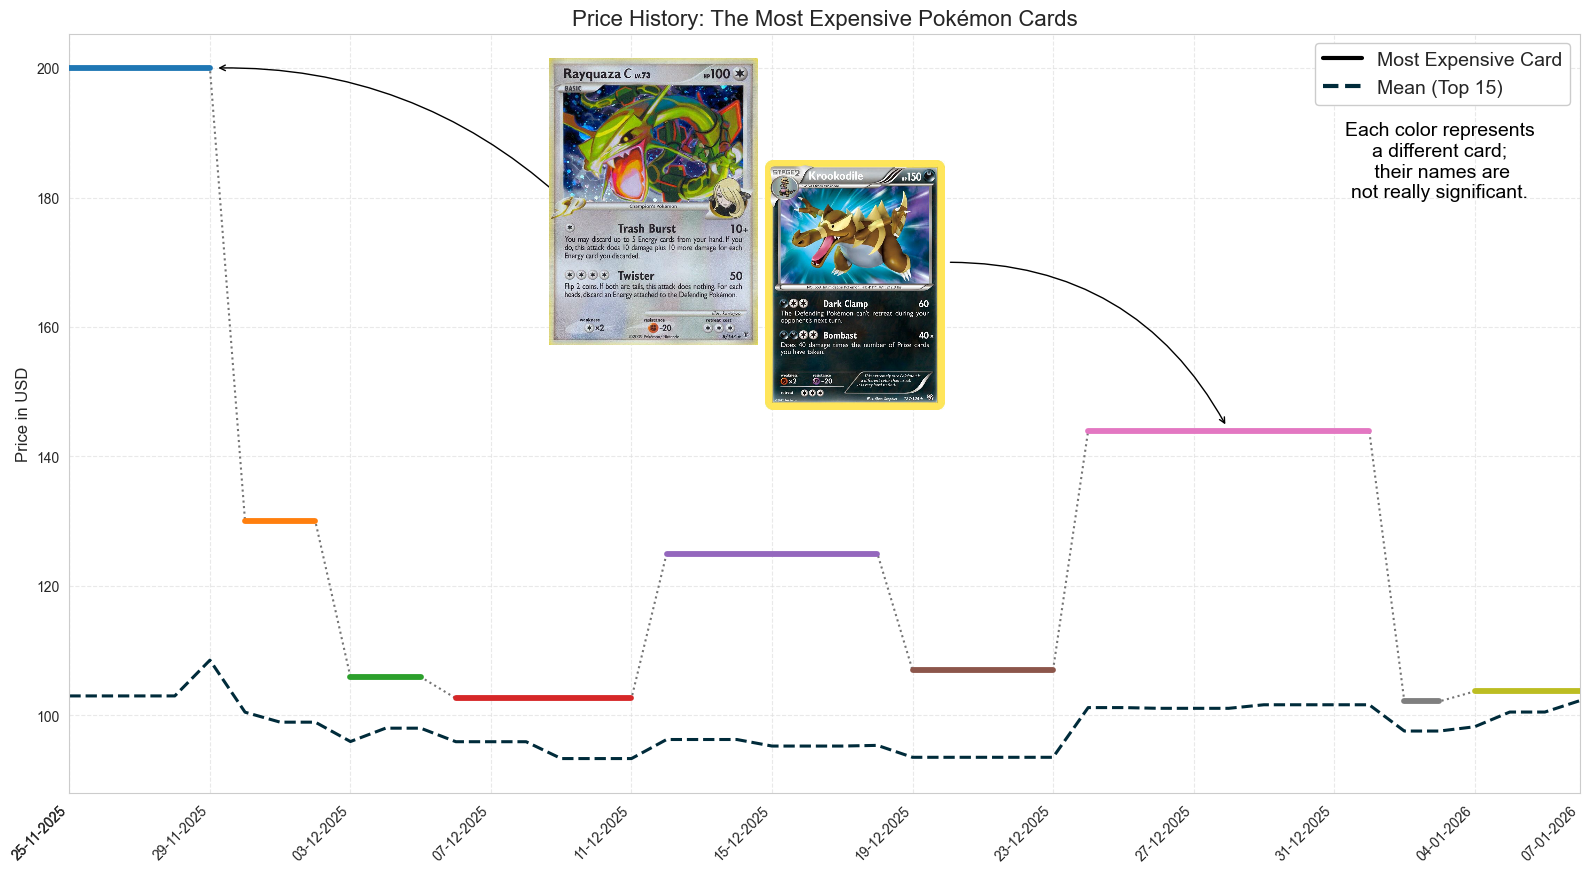

In [7]:
#dla każdego dnia szukamy indeksu karty z najwyższą ceną
idx = top_cards_data.groupby('prices.Date:')['price'].idxmax()
#wybieramy karty (wiersze) z najwyższą ceną (spełniające idx)
winners_data = top_cards_data.loc[idx].sort_values('prices.Date:')

max_row_idx = top_cards_data['price'].idxmax()
max_row = top_cards_data.loc[max_row_idx]
me_name = max_row['full_name']

#tu liczę w jakich fragmentach mają się pojawiać kolorowe linie oznaczające konkretną kartę (środkowa data i jak długo się utrzymuje jako najdroższa)
specific_card_data = top_cards_data[top_cards_data['full_name'] == me_name]
middle_date = specific_card_data['prices.Date:'].min() + ((specific_card_data['prices.Date:'].max() - specific_card_data['prices.Date:'].min()) / 2)
time_diff = specific_card_data['prices.Date:'].max() - specific_card_data['prices.Date:'].min()


#wykres
plt.figure(figsize=(16, 9))
sns.set_style("whitegrid")
ax = plt.gca()

#wykres ze średniej z top 15
sns.lineplot(
    data=top_cards_data, 
    x='prices.Date:', 
    y='price', 
    estimator='mean', 
    errorbar=None,
    linestyle='--',
    linewidth=2.2, 
    color='#002b3a', 
    label='Mean (Top 15)', 
    ax=ax, 
    zorder=1
)

#wykres z maksymalnej ceny - szkielet
sns.lineplot(
    data=top_cards_data, 
    x='prices.Date:', 
    y='price', 
    estimator='max', 
    errorbar=None,
    linestyle=':', 
    linewidth=1.5, 
    color='#747474',
    ax=ax, 
    zorder=2, 
    label='Max price' 
)

#linie odznaczające najdroższe karty
sns.lineplot(
    data=winners_data,
    x='prices.Date:',
    y='price',
    hue='full_name',
    linestyle='-', 
    linewidth=4.2,
    marker=None,
    ax=ax,
    zorder=3,
    palette='tab10',
    legend=False 
)

#wstawienie obrazków 2 najdroższych kart
image_path1 = 'rayquazaC_most_expensive1.jpg'
img1 = Image.open(image_path1)
imagebox1 = OffsetImage(img1, zoom=0.25)
ab1 = AnnotationBbox(
    imagebox1,
    xy=(middle_date, 100),
    xybox=(370, 370),
    boxcoords="offset points",
    frameon=False,
    zorder=20,
)
ax.add_artist(ab1)

image_path2 = 'krookodile_most_expensive2.jpg'
img2 = Image.open(image_path2)
imagebox2 = OffsetImage(img2, zoom=0.18)
ab2 = AnnotationBbox(
    imagebox2,
    xy=(middle_date, 100),
    xybox=(515, 310),
    boxcoords="offset points",
    frameon=False,
    zorder=20,
)
ax.add_artist(ab2)

#strzałki
ax.annotate(
    "",  
    xy=(pd.Timestamp('2025-11-29'), 200), #gdzie strzałka celuje
    xytext=(pd.Timestamp('2025-12-09'), 180), #gdzie strzałka startuje
    xycoords='data',  #używam współrzędnych po dacie
    textcoords='data',
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        shrinkB=6,
        linewidth=1,
        connectionstyle="arc3,rad=0.2")
)
ax.annotate(
    "",
    xy=(pd.Timestamp('2025-12-28'), 144),
    xytext=(pd.Timestamp('2025-12-20'), 170),
    xycoords='data',
    textcoords='data',
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        shrinkB=5,
        linewidth=1,
        connectionstyle="arc3,rad=-0.3")
)

plt.title('Price History: The Most Expensive Pokémon Cards', fontsize=16)
plt.xlabel("", fontsize=12)
plt.ylabel("Price in USD", fontsize=12)

ax.grid(visible=True, which='major', axis='both', color='#e0e0e0',
        linestyle='--', linewidth=0.8, alpha=0.7, zorder=0)

#data - ustawienia osi i format daty
#data początkowa i końcowa
start_date = top_cards_data['prices.Date:'].min()
end_date = top_cards_data['prices.Date:'].max()
#lista dat co 4 dni (wstępna)
middle_ticks = pd.date_range(start=start_date, end=end_date, freq='4D')
#ustalam margines i filtruje dane, jeśli końcowa data jest obok ostatniej daty z middle_thicks, to pomija ostatniego middle_thicks
filtered_middle = [t for t in middle_ticks if (end_date - t) > pd.Timedelta(days=1)]
all_ticks = [start_date] + filtered_middle + [end_date]
ax.set_xticks(all_ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xlim(start_date, end_date)
plt.xticks(rotation=45, ha='right')

#ręczna legęda — biblioteka Seaborn tworzy automatyczną legedę z nazwami kart, które niekonieczne nas interesują  
h_max, = ax.plot([], [], color='black', linewidth=3, linestyle='-', label='Most Expensive Card')
h_mean, = ax.plot([], [], color='#002b3a', linewidth=3, linestyle='--', label='Mean (Top 15)')

plt.legend(
    handles=[h_max,h_mean], 
    loc='upper right', 
    fontsize=14,
    frameon=True,
    facecolor='white',
    framealpha=1
)

plt.text(pd.Timestamp('2026-01-03'), 180, 'Each color represents\na different card;\n their names are\nnot really significant.', ha='center', 
         fontsize=14, color='black')

plt.tight_layout()
plt.savefig('TCG_prices.png', dpi=100)
plt.show()